# Giriş
Merhaba arkadaşlar, tensorflow kütüphanesini öğrenme serüvenimizde dördüncü adımına hoş geldiniz. Bu adımdan basit metin sınıflandırması gerçekleştireceğiz. Bu adım [tutorial](https://www.tensorflow.org/tutorials) kısmının, Beginner kısımı içerisinde bulunan Basic text classification bölümündeki çalışma adımıdır.

In [ ]:
# Kullanacağımız kütüphaneleri yükleyelim
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
print(tf.__version__)

2.15.0


Bu çalışmada duygu analizi yapacağız, veri seti içerisinde olan metinlerin olumlu mu yoksa olumsuz mu olduğunu modelimize tahmin ettirmeye çalışacağız. Bu çalışma iki sınıf(binary classification) üzerinde sınıflandırma yapılacak. Veri seti olarak film inceleme veri kümesi olan IMDB veri setini kullanacağız. Veri seti içerisinde 50 bin inceleme bulunmaktadır. Bu verilerin 25 bini eğitim(train) 25 bini test veri seti olarak kullanılacaktır.

In [ ]:
# Veri setinin yüklenmesi
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar = True, cache_dir = ".", cache_subdir = "")
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

In [ ]:
# İndirdiğimiz ver seti klasörü içerisindeki dosyalar
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'test', 'README', 'train']

In [ ]:
"""
pos, içersinde pozitif incelemeler bulunmakta
neg, içerisinde negatif incelemeler bulunmakta
"""
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt',
 'neg']

In [ ]:
# Pozitif bir incelemeyi göreksiniz!
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
# Veri setinin içe aktarılması
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', # veri setinin bulunduğu dizin
    batch_size = batch_size, # batch boyuru (Her bir adımda kullanılacak veri miktarı!)
    validation_split = 0.2, # verisetinin %20 validation(doğrulama) için ayrılacak
    subset = "training", # Veri setinin eğitim veri seti oldğunu belirtir
    seed = seed # Rastgelelilik içinb kullanılan değer
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


**tf.keras.utils.text_dataset_from_directory**<br>
fonksiyonunu kullanarak dosya içerisinde bulunan train veri setini içe aktardık ve 25 bin verinin 20 bin verisini eğitim, 5 bin tanesini validation verisi olarak kullanmak için ayırdık. Validation veri seti ile daha yeni karşılaşıyoruz, peki nedir bu Validation veri seti:<br>
Validation dataset (doğrulama veri seti), makine öğrenimi modellerinin performansını değerlendirmek ve hiperparametre ayarlarını optimize etmek için kullanılan bir veri setidir. Eğitim sürecinde modelin genelleme yeteneğini ölçmek için eğitim veri setinden ayrılan bir veri kümesidir.

In [ ]:
# Train veri kümesi içerisindeki ilk üç veri
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review ", text_batch.numpy()[i])
    print("Label ", label_batch.numpy()[i])

Review  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label  0
Review  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get in

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [ ]:
# Validation dataset
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# Test veri seti
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Veri setini indirdik modelimizde kullanmak için tensorflow kütüphanesinden fayadalanarak içede aktardık. Şimdi, veri setinin model için hazırlama aşamasına başlayacağız. Yapılacak olan işlemler standartlaştırma(standardize) tokenleştirme(tokenize) ve vektörleştirme(Vectorize) işlemleri olacaktır. Kısaca bu adımların ne olduğundan bahsedeyim:<br>
Standardizasyon, metni ön işleme sürecine verilen isimdir ve genellikle noktalama işaretleri veya HTML öğelerini çıkarmak gibi işlemleri içerir. Bu adım, veri setini basitleştirmek için yapılır. Tokenizasyon ise, metin dizelerini token adı verilen parçalara bölme işlemidir. Örneğin, bir cümleyi boşluk karakterlerine göre kelimelere ayırmak tokenizasyona örnek olabilir. Vektörleştirme ise, tokenlarin sayılara dönüşürme işlemidir, böylece bu sayılar sinir ağına beslenebilinir hale getirilicektir.


In [ ]:
# Veri setinin hazırlanması
# Metinler içerisindeki html kodlarını ve noktalama işaretlerini çıkarma fonksiyonum
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Sizlere girişte anlattığım adımları çıktı olarak göstermek istedim. Modelimiz son adımdaki vektörize edilmiş modelimiz ile beslenecek.

In [ ]:
# Train veri kümesini hazırlayalım
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

Yukarıda ilk satırda metinin orjinal halini görmektesiniz, label kısmında metinin hangi sınıfa ait olduğunu görüyoruz. Son kısımda ise metinin vektorize edilmiş hali olan sayı formatına çevirilmiş halini görüyorsunuz. Son kısımdaki sıfırlar metinin 250 değerinden kısa olduğu için doldurma olarak alınmış ve 250 değerine ulaşmasını sağlamıştır.

In [ ]:
print("1233 --> ", vectorize_layer.get_vocabulary()[1233]) # 1233 değerin kelime karşılığı!
print("5 --> ", vectorize_layer.get_vocabulary()[5])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary()))) # vectorize_layer.get_vocabulary() fonksiyonun içerisinde toplam kaç kelime olduğu sorgusu

1233 -->  tough
5 -->  of
Vocabulary size: 10000


In [ ]:
# Hazırladığım Vectorizer fonksiyonunu train, val ve test veri kümelerine uyguluyorum.
# Bu adımdan sonra tüm verilerimiz vectorize hale gelmiş olacaktır.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

**Veri kümesinin yapılanması ve eğitime hazır hale gerilmesi**<br>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

**'cache()'**<br>
  Veri kümesini önbelleğe alarak okuma işlemlerini hızlandırır. Örneğin veri kümesini diske veya belleğe saklayarak her seferinde diskten okuma ihtiyacını ortadan kaldırır.

**'prefetch()'**<br>
  Eğitim sırasında veri kümesini önceden yükleyerek eğitim sürecini hızlandırır. Bu işlem, veri işlemenin model eğitimiyle paralel olarak gerçekleşmesini sağlar, böylece veri yükleme gecikmelerini minimize edilir.

**'buffer_size = AUTOTUNE'**<br>
  parametres, TensorFlow'un en uygun tampon boyutunu otomatik olarak belirlemesini sağlar.

Bu adımda veri kümesini eğitime hazır hale getirdik artık sınıflandırma için modelimizi oluşturabilir ve modelimizi eğitebiliriz.

In [ ]:
# Model oluşturma
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

Tensorflow kütüphanesi ile oluşturuduğumuz modelde:<br>

**layers.Embedding(max_features, embedding_dim)**<br>
Bu satırda, gömme katmanı oluşturuyoruz. Bu katman, bir kelime haznesindeki her kelimenin bir temsili olarak kullanılan vektörlerin hesaplanmasını sağlar. Gömme katmanı bir giriş dizisini alır(örneğin, bir cümlenin kelime dizisi) ve her kelimeyi belirtilen boyuttaki bir vektör ile temsil eder. Bu vektör modelin eğitimini sırasında güncellenir ve kelime temsillerini öğrenir. "max_feature", Kelime haznesinin boyutunu belirler. "embedding_dim", Her kelimenin temsil edileceği vektörün boyutunu belirler. Yani, her kelime bir "embedding_dim" boyutunda bir vektörle temsil edilir.

**layers.Dropout**<br>
Aşırı öğrenmenin önüne geçmek için bu katmandan önce öğrenilen verinin yüze yirmisini(0.2) unutur.

**layers.GlobalAveragePooling1D()**<br>
 katmanı, 1D veri dizileri üzerinde kümeleme işlemi uygular. Bu işlem, her bir özellik boyunca ortalama değeri hesaplar ve bu ortalama değerleri tek bir vektörde birleştirir. Bu katman, özellikle metin verileri gibi değişken uzunluktaki girdilerin sabit boyutta bir çıkışla temsil edilmesi gerektiği durumlarda kullanışlıdır. Örneğin, bir cümlenin kelime dizisi, her kelimenin gömme vektörlerini içerir. Bu vektörler farklı uzunluklarda olabilir, ancak GlobalAveragePooling1D() katmanı her bir gömme vektörü boyunca ortalama değeri hesaplar ve böylece sabit boyutta bir çıkış elde edilir.

In [ ]:
# Loss fonksiyonu ve optimizasyon fonksiyonun berlenmesi
model.compile(loss = losses.BinaryCrossentropy(),
              optimizer = 'adam',
              metrics = [tf.metrics.BinaryAccuracy(threshold = 0.5)])

**metrics = [tf.metrics.BinaryAccuracy(threshold = 0.5)]**<br>
Değerlendirme metrikleri, modelin performansını değerlendirmek için kullanılan ölçümlerdir. Burada kullanılan "BinaryAccuracy" doğru sınıflandırma oranını hesaplar. threshold = 0.5 parametreleri, tahmin edilen sınıfın kesme eşiğini belirtir, yani 0.5'ten büyükse tahmin edilen sınıf 1 olarak kabul edilir, aksi takirde 0 olarak kabul edilir.

In [ ]:
epochs = 10
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6621 - binary_accuracy: 0.6966 - val_loss: 0.6119 - val_binary_accuracy: 0.7750
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5458 - binary_accuracy: 0.8034 - val_loss: 0.4960 - val_binary_accuracy: 0.8238
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4425 - binary_accuracy: 0.8461 - val_loss: 0.4184 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3770 - binary_accuracy: 0.8659 - val_loss: 0.3727 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3335 - binary_accuracy: 0.8792 - val_loss: 0.3439 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3036 - binary_accuracy: 0.8893 - val_loss: 0.3254 - val_binary_accuracy: 0.8698
Epoch 7/10
625/625 [==============================] - 6s 10ms

In [ ]:
# Model değerlendirme
loss, accuracy = model.evaluate(test_ds)

print("loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3104 - binary_accuracy: 0.8721
loss:  0.31043311953544617
Accuracy:  0.8721200227737427


Eğitim sonucunda modelimiz kayıp değeri(loss) 0.31, doğruluk(accuracy) değeri ise 0.87 çıktı. Sonuçlar güzel yalnız loss değeri bence yüksek çıktı bu durumu modelin parametlerini düzelterek düşürebiliriz veya fazladan veri ekleyerekde yapabiliriz. Şimdilik tutorialdan kopmadan devem edelim.

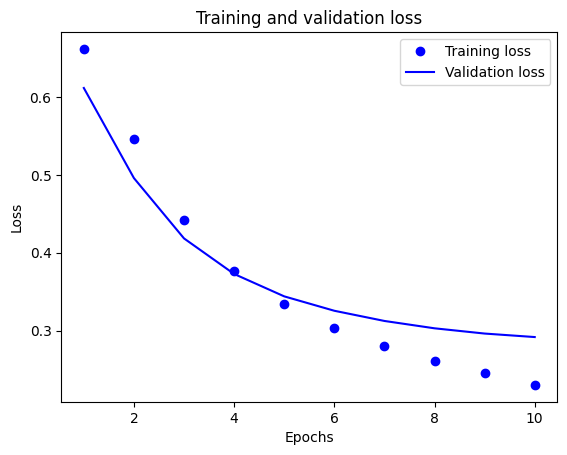

In [ ]:
# Sonuçların görselleştirilmesi
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

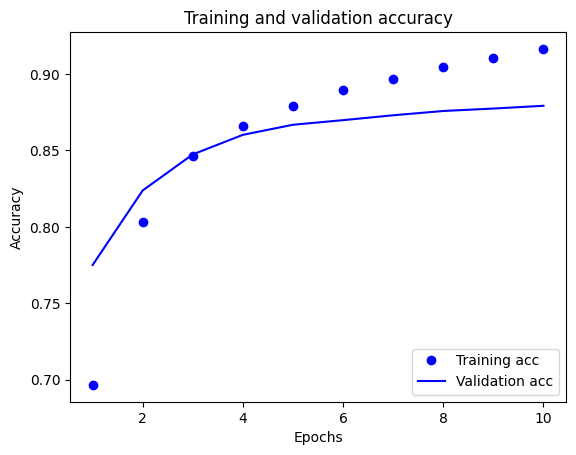

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Traning loss ve validation loss giderek düşmeye başlamış bu güzel bir durum. Traning acc ve validation acc değerleride giderek artıyor bu da güzel bir durum yalnız traning acc değeri validation acc değerinden fazla bu durumunun nedeni eğitim esnasında modelin tranin verileri ile eğitildiğinden dolayıdır model önceden görmüş olduğu verilerde yüksek performans sergilemesi normal ama validation acc değerinin traning acc değerinden düşük çıkması aşırı uydurmanın bir örneğidir. Bu durum ile mücadele etmek için eğitimi erken durdurma, yeni veri ekleme, model parametrelerini optimize etme vb. gibi yollara başvurulabilinir.

In [ ]:
# Modeli dışa aktarma
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation("sigmoid")
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits = False), optimizer = "adam", metrics = ["accuracy"]
)

loss, accuracy = export_model.evaluate(raw_test_ds)

782/782 [==============================] - 5s 6ms/step - loss: 0.5880 - accuracy: 0.5000


In [ ]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 [==============================] - 0s 136ms/step


array([[0.64572835],
       [0.6034256 ],
       [0.5840532 ]], dtype=float32)

Dışarı aktardığımız modele kendi yazdığımız metinleri veriyoruz ve hepsine olumlu sonuç veriyor çünkü biz model eğitiminde 0.5'den yukarı sonuçlar için olumlu 0.5'ten düşünklere olumsuz şeklinde eğitimi yapmıştık. Dışa aktarılan model sonucunu değerlendirdiğimizde ise loss(kayıp) değeri doğruluk(accuracy) değerinden yüksek çıkması model eğitiminde sorun olduğunu ve doğru sonuç vermesinin zor olduğunu gösteriyor.

Bu çalışmanında sonuna geldik bu çalışmanın detaylı halini tensorflow tutorial içerisindeki begginer - Basic text classification bölümünden ulaşabilirsiniz. Çalışmalarda her defasını belirtiyorum, bu çalışmalar tensorflow kütüphanesini daha iyi bir şekilde anlamak ve üzerinde çalışmak için yapıyorum. Kodlara eklediğim açıklamalar benim yorumlarım veya araştırma sonucu eklediğim metinlerdir arkadaşlar. Çalışmalarımı takip ettiğiniz için teşekkür ederim, daha yolumuz bitmedi Tensorflow yolculuğumuz devam edecek!